American Sign Language (ASL) Recognition using CNN
------------------------------------------------
This script implements a Convolutional Neural Network (CNN) for recognizing
American Sign Language (ASL) alphabet signs from images. It includes data loading,
model training with mixed precision, visualization, and evaluation components.

The model architecture is based on a simple CNN with multiple convolutional layers
followed by dense layers for classification of 27 ASL signs (A-Z).

`Author: Pourya`

`Date: 2024-11-09`

In [5]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [3]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('lexset/synthetic-asl-alphabet', path="/content/asl", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/lexset/synthetic-asl-alphabet


In [4]:
import os

def count_files_recursive(directory):
  """Counts the number of files recursively within a given directory.

  Args:
    directory: The path to the directory.

  Returns:
    The total number of files found.
  """
  total_files = 0
  for root, _, files in os.walk(directory):
    total_files += len(files)
  return total_files

# Example usage (replace with your actual directory path):
directory_path = "/content/asl"
file_count = count_files_recursive(directory_path)
print(f"Total number of files in '{directory_path}': {file_count}")

Total number of files in '/content/asl': 27001


In [5]:
import os
import numpy as np
import tensorflow as tf
from typing import Tuple
from PIL import Image
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import seaborn as sns

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Enable XLA
tf.config.optimizer.set_jit(True)

# Step 2: Define Constants

In [10]:
BATCH_SIZE: int = 64
IMAGE_SIZE: int = 128
AUTOTUNE = tf.data.AUTOTUNE
INPUT_SHAPE: Tuple[int, int, int] = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_CLASSES: int = 27

# Paths
TRAIN_PATH: str = "/content/asl/Train_Alphabet"
TEST_PATH: str = "/content/asl/Test_Alphabet"
TFRECORD_DIR: str = "/content/asl/tfrecords"

# Create TFRecord directory if it doesn't exist
if not os.path.exists(TFRECORD_DIR):
    os.makedirs(TFRECORD_DIR)

# Step 3: Define TFRecord Functions

In [7]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

@tf.function
def parse_tfrecord(example_proto):
    """Parse TFRecord data."""
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    features = tf.io.parse_single_example(example_proto, feature_description)

    image = tf.io.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE, 3])
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(features['label'], tf.int32)
    label = tf.one_hot(label, NUM_CLASSES)

    return image, label

# Step 4: Create TFRecords from Training Data

In [8]:
print("Creating training TFRecords...")
writer = tf.io.TFRecordWriter(f"{TFRECORD_DIR}/train.tfrecord")

class_dirs = sorted(os.listdir(TRAIN_PATH))
for class_idx, class_name in enumerate(class_dirs):
    class_path = os.path.join(TRAIN_PATH, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
                img_array = np.array(img)

            feature = {
                'image': _bytes_feature(img_array.tobytes()),
                'label': _int64_feature(class_idx)
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

writer.close()

Creating training TFRecords...


# Step 5: Create TFRecords from Test Data

In [11]:
print("Creating test TFRecords...")
writer = tf.io.TFRecordWriter(f"{TFRECORD_DIR}/test.tfrecord")

class_dirs = sorted(os.listdir(TEST_PATH))
for class_idx, class_name in enumerate(class_dirs):
    class_path = os.path.join(TEST_PATH, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
                img_array = np.array(img)

            feature = {
                'image': _bytes_feature(img_array.tobytes()),
                'label': _int64_feature(class_idx)
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

writer.close()

Creating test TFRecords...


# Step 6: Create Optimized Datasets

In [12]:
# Create training dataset
train_dataset = tf.data.TFRecordDataset(f"{TFRECORD_DIR}/train.tfrecord")
train_dataset = train_dataset.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.cache()  # Cache the data
train_dataset = train_dataset.prefetch(AUTOTUNE)  # Prefetch next batch

# Create test dataset
test_dataset = tf.data.TFRecordDataset(f"{TFRECORD_DIR}/test.tfrecord")
test_dataset = test_dataset.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(AUTOTUNE)

# Step 7: Display Sample Images

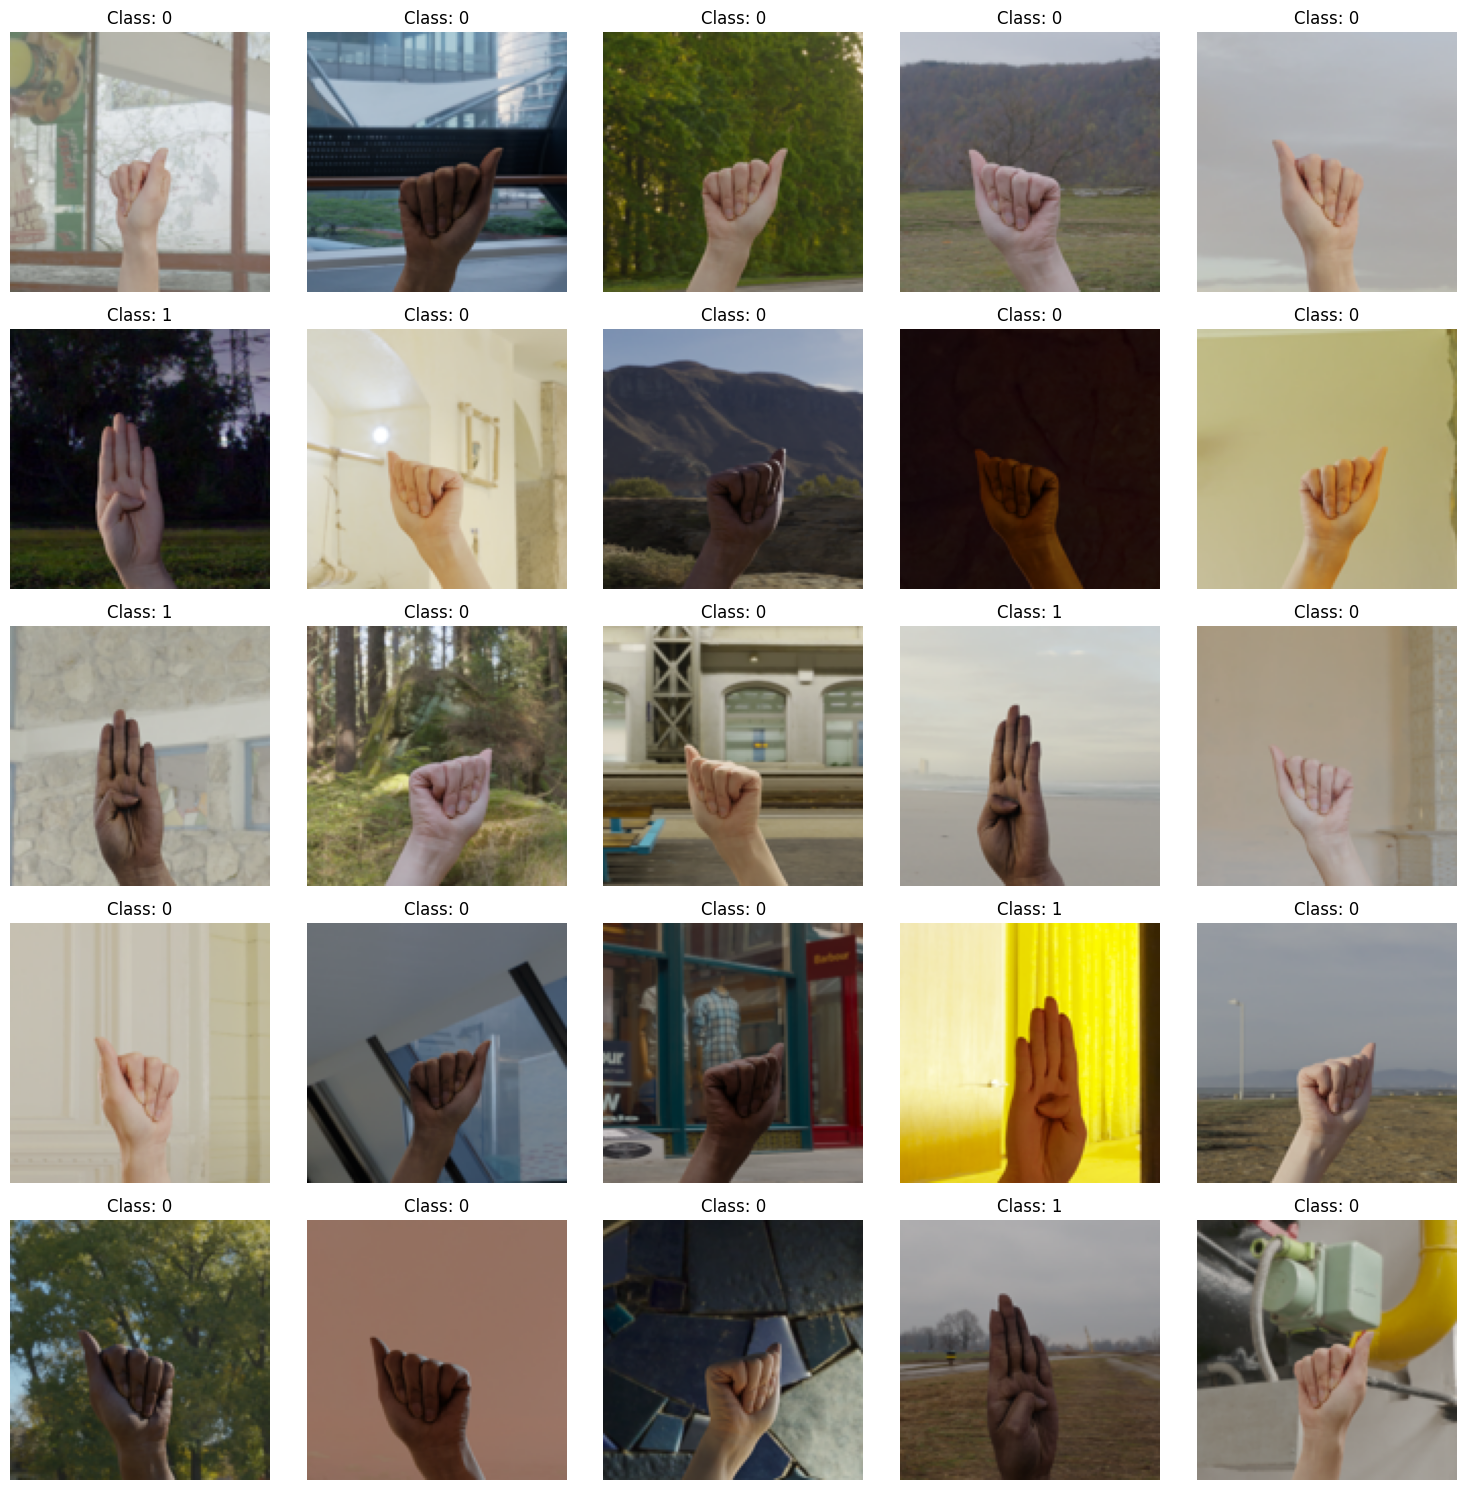

In [13]:
plt.figure(figsize=(15, 15))
for i, (images, labels) in enumerate(train_dataset.take(5)):
    for j in range(min(5, images.shape[0])):
        plt.subplot(5, 5, i*5 + j + 1)
        plt.imshow(images[j].numpy())
        plt.title(f'Class: {np.argmax(labels[j])}')
        plt.axis('off')
plt.tight_layout()
plt.show()

# Step 8: Build Model

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile model with mixed precision optimizer
optimizer = tf.keras.optimizers.Adam()
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,242,043 (12.37 MB)

 Trainable params: 3,242,043 (12.37 MB)

 Non-trainable params: 0 (0.00 B)

# Step 9: Train Model

In [16]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=test_dataset,
    verbose=1
)

Epoch 1/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1666 - loss: 2.5673 - val_accuracy: 0.0370 - val_loss: 9.5320
Epoch 2/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1576 - loss: 2.6943 - val_accuracy: 0.0370 - val_loss: 3.9934
Epoch 3/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1014 - loss: 3.6292 - val_accuracy: 0.0370 - val_loss: 3.5094
Epoch 4/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0322 - loss: 3.3883 - val_accuracy: 0.0370 - val_loss: 3.9283
Epoch 5/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2150 - loss: 2.2863 - val_accuracy: 0.0415 - val_loss: 8.5823
Epoch 6/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3444 - loss: 1.7979 - val_accuracy: 0.0630 - val_loss: 8.6422
Epoch 7/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4524 - loss: 1.6121 - val_accuracy: 0.1122 - val_loss: 6.9171
Epoch 8/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6032 - loss: 1.1895 - val_accu

# Step 10: Plot Training History

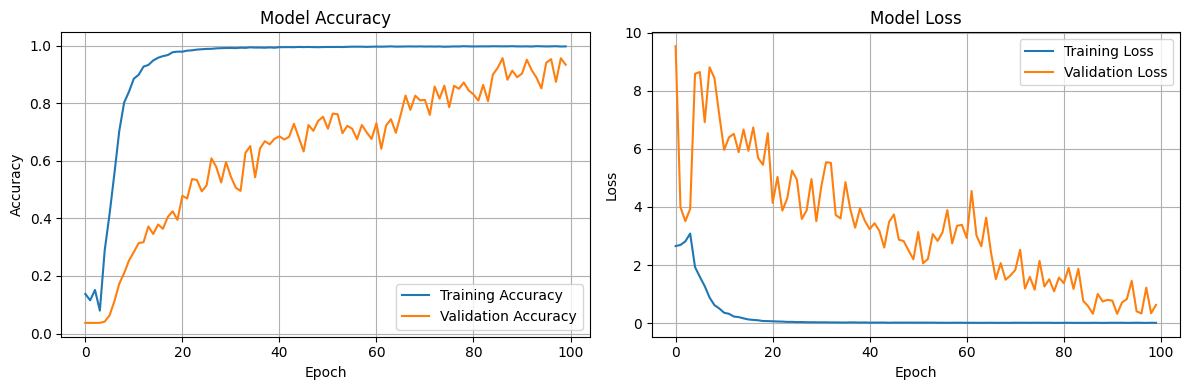

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 11: Evaluate Model

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       100
           1       0.99      1.00      1.00       100
           2       0.98      0.97      0.97       100
           3       0.99      0.99      0.99       100
           4       0.98      0.96      0.97       100
           5       1.00      0.94      0.97       100
           6       1.00      0.94      0.97       100
           7       1.00      0.94      0.97       100
           8       1.00      0.95      0.97       100
           9       1.00      0.96      0.98       100
          10       1.00      0.75      0.86       100
          11       1.00      0.80      0.89       100
          12       1.00      0.93      0.96       100
          13       0.99      0.90      0.94       100
          14       1.00      0.91      0.95       100
          15       0.99      0.93      0.96       100
          16      

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


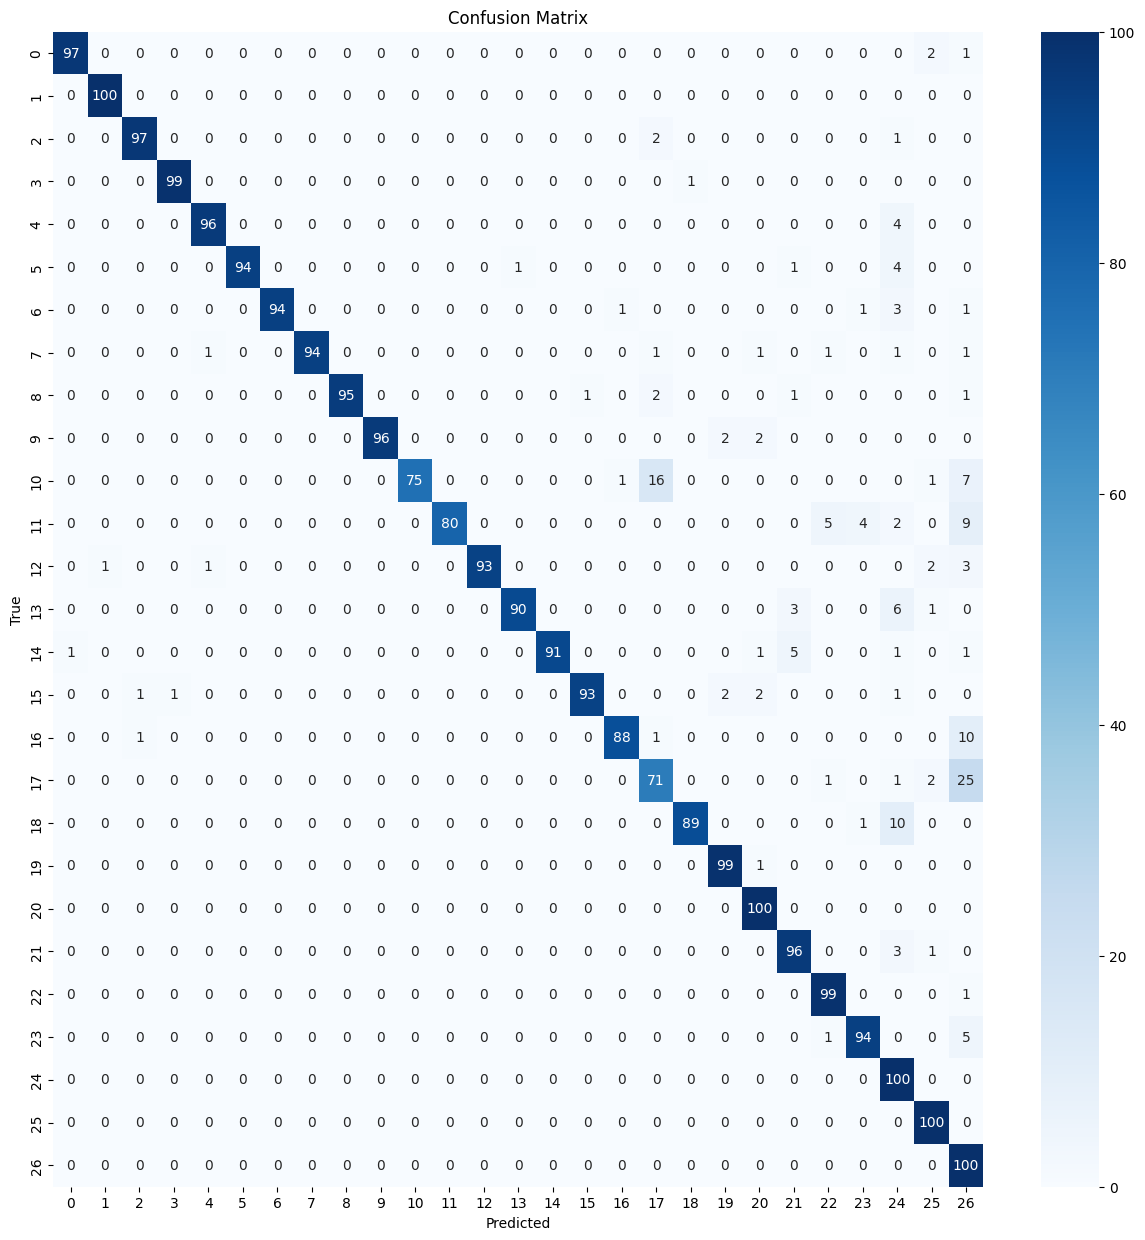

In [19]:
# Get predictions
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([labels.numpy() for images, labels in test_dataset])
y_true_classes = np.argmax(y_true, axis=1)

# Print classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# Plot confusion matrix
plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 12: Save Model

In [20]:
model.save('asl_model.keras')
print("\nModel saved as 'asl_model.keras'")


Model saved as 'asl_model.keras'


# Step 13: Function for Single Image Prediction

In [23]:
@tf.function
def predict_sign(image_path: str) -> int:
    """
    Predicts the ASL sign in a given image.
    Args:
        image_path: Path to the image file
    Returns:
        int: Predicted class index
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([128, 128, 3])
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, 0)

    prediction = model(img, training=False)
    return tf.argmax(prediction[0])

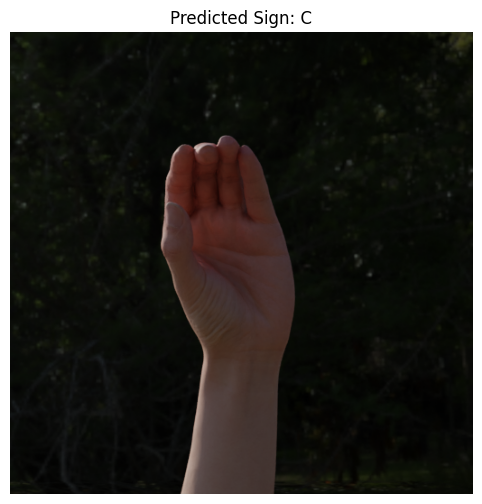

Predicted Class: C


In [27]:
# Define class names list
CLASS_NAMES = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
               'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# Make prediction
test_image_path = '/content/asl/Test_Alphabet/C/02409944-2e03-4882-83c9-238732fe18d2.rgb_0000.png'
predicted_class_idx = predict_sign(test_image_path)
predicted_class_name = CLASS_NAMES[predicted_class_idx]

# Display image and prediction
img = tf.io.read_file(test_image_path)
img = tf.image.decode_image(img, channels=3)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f'Predicted Sign: {predicted_class_name}')
plt.axis('off')
plt.show()

print(f'Predicted Class: {predicted_class_name}')